In [2]:
import numpy as np
import pandas as pd
#%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Task 1: Data dimensionality, distance-based classifiers
Excercise with mnist digit dataset. Lets first load the data and take a peek:

In [3]:
X_train = pd.read_csv('./data/train_in.csv',header=None)
Y_train = pd.read_csv('./data/train_out.csv',header=None)
df_train = X_train.copy()
df_train['label']=Y_train

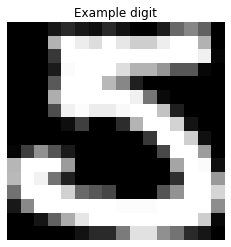

In [4]:
def show_number(nr,data):    
    X=np.array(data)
    X=np.reshape(X[nr,:],(16,16))
    imgplot = plt.imshow(X,cmap='gray')
    plt.axis('off')
    
    plt.title('Example digit')
    plt.show()
show_number(np.random.randint(0,10),X_train)


How big is the difference between numbers?

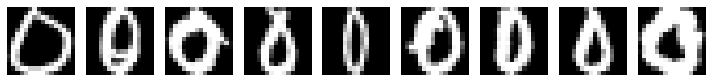

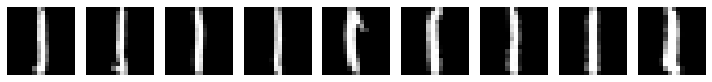

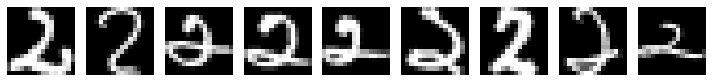

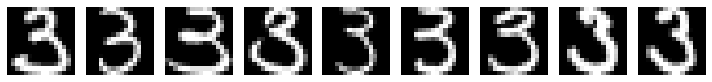

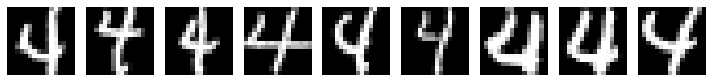

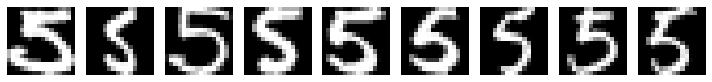

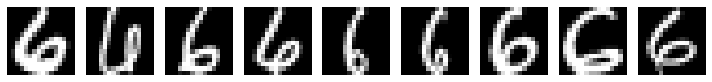

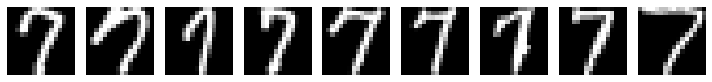

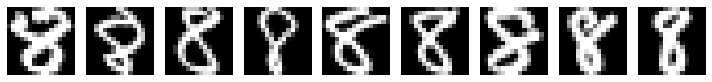

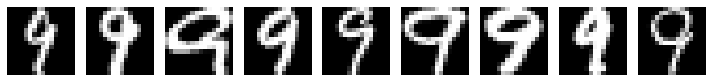

In [5]:
def get_image(nr,data):
    if 'label' in data.columns:
        data=np.array(data.drop('label',axis=1))
    else:
        data=data.values
    return np.reshape(data[nr,:],(16,16))

def display_multiple_img(images, rows = 3, cols=3):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(10,10))
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title],cmap='gray')
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

def display_digits(digit,data,rows,cols):
    total_images = rows*cols
    index=data.loc[data.label==digit].index[:total_images]
    images = {'Image'+str(i):get_image(i,data) for i in index}
    display_multiple_img(images, rows, cols)

    
for i in range(10):
    display_digits(i,df_train,rows=1,cols=9)

#### part 1
For each digit d in range(10) calculate the 'centre': $c_{d}$ as the mean of allcoordinates of vectors constructin $C_{d}$.
Once we have these centers, we can easily classify new images.

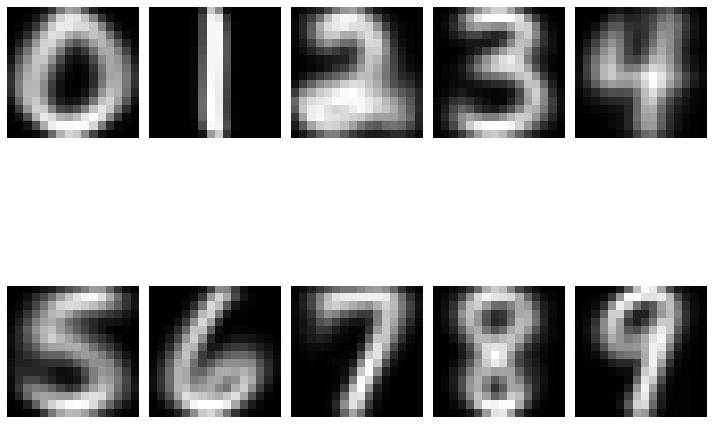

In [6]:
c_ds=df_train.groupby('label').mean()

images = {'Image'+str(i):get_image(i,c_ds) for i in range(10)}
display_multiple_img(images, 2,5)

Next, calculate the distances between the centers of the 10 clouds, $dist_{ij} = dist(c_{i}; c_{j} )$, for
$i,j = 0,1,...9$.

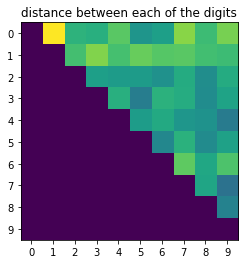

In [7]:
from itertools import product
dist_ij=np.zeros((10,10))
for i,j in product(range(10),range(10)):
    if j>=i:
        dist_ij[i,j]=np.linalg.norm(c_ds.iloc[i].values-c_ds.iloc[j].values)
imgplot = plt.imshow(dist_ij)
plt.title(label='distance between each of the digits')
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

#### Question
Given all these distances, try to say something about the expected accuracy of your
classifier. What pairs of digits seem to be most difficult to separate?
#### Answer
Looking at the graph i would suspect its hard to distinguish between 4 and 9, 7 and 9, 8 and 9, 3 and 5.  

#### Part 2: expirement with dimensionality reduction: PCA, LLE and t-SNE

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from matplotlib import cm

In [9]:
#Dimension reduction
pca = PCA(n_components=2)
lle = LocallyLinearEmbedding(n_components=2)
tsne = TSNE(n_components=2)

methods={'pca':pca,'lle':lle,'tsne':tsne}
dfs=dict()
for key in methods:
    X=methods[key].fit_transform(X_train)
    df=pd.DataFrame(X)
    df['label']=Y_train
    dfs[key]=df

In [10]:
def scatter_plot(c_ds,title):
    fig, ax = plt.subplots()
    colors={0:'tab:red',1:'tab:blue',2:'tab:orange',3:'tab:green',4:'tab:purple',5:'tab:brown',6:'tab:pink',7:'tab:gray',8:'tab:olive',9:'tab:cyan'}
    for key in colors:
        x=c_ds.loc[c_ds.label==key].values[:,0]
        y=c_ds.loc[c_ds.label==key].values[:,1]
        ax.scatter(x,y, c=colors[key], label=key,
                   alpha=0.3, edgecolors='none')
    
    
    average=c_ds.groupby('label').mean()
    ax.scatter(average.values[:,0],average.values[:,1])
    for i in range(10):
        label = f"{c_ds.index[i]}"
        plt.annotate(label, # this is the text
             (average.values[i,0],average.values[i,1]), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(0,10), # distance from text to points (x,y)
             ha='center') # horizontal alignment can be left, right or   
    ax.legend()
    plt.title(title)
    plt.show()

Distributions after dimension reduction:

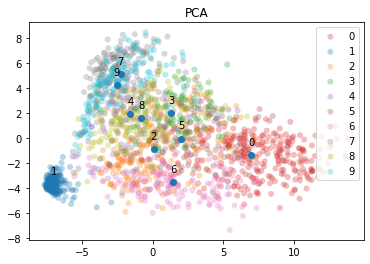

In [11]:
scatter_plot(dfs['pca'],'PCA')

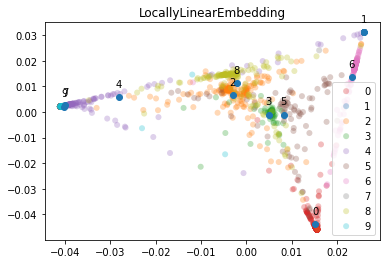

In [12]:
scatter_plot(dfs['lle'],'LocallyLinearEmbedding')

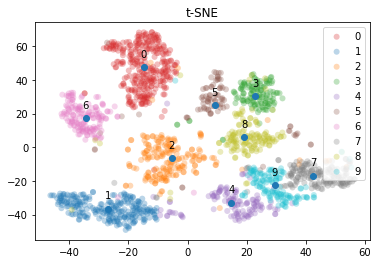

In [13]:
scatter_plot(dfs['tsne'],'t-SNE')

#### Part 3: implement the simplest distance-based classifier

In [14]:
class DistanceBasedClassifier:

    def __init__(self):
        self.c_ds=None
        
    def fit(self,X,Y):
        df_train = X.copy()
        df_train['label']=Y
        self.c_ds=df_train.groupby('label').mean()
    
    def predict(self,X):
        probability_matrix=pd.DataFrame()
        for i in range(10):
            df=X-self.c_ds.iloc[i]
            probability_matrix[i]=np.sqrt(np.multiply(df.abs(),df.abs()).sum(axis=1))
        predictions=np.argmin(probability_matrix.values,axis=1)
        #self.probabilities=1-(np.min(dbc.probability_matrix,axis=1)/np.sum(dbc.probability_matrix,axis=1))
        return predictions
    
    def score(self,X,Y):
        predictions=self.predict(X)
        acc=(np.sum(predictions==Y.values.T))/len(Y)
        return acc

In [15]:
dbc=DistanceBasedClassifier()
dbc.fit(X_train,Y_train)

In [16]:
prediction=dbc.predict(X_train)

Percentage correctly classified in trainset:

In [17]:
dbc.score(X_train,Y_train)

0.8635032220269478

In [18]:
X_test = pd.read_csv('./data/test_in.csv',header=None)
Y_test = pd.read_csv('./data/test_out.csv',header=None)

In [19]:
Y_pred_dbc=dbc.predict(X_test)

Percentage correctly classified in testset:

In [20]:
dbc.score(X_test,Y_test)

0.804

In [21]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred_dbc))

              precision    recall  f1-score   support

           0       0.90      0.79      0.85       224
           1       0.91      0.99      0.95       121
           2       0.85      0.68      0.76       101
           3       0.75      0.77      0.76        79
           4       0.67      0.80      0.73        86
           5       0.72      0.69      0.70        55
           6       0.75      0.87      0.80        90
           7       0.85      0.78      0.81        64
           8       0.74      0.79      0.76        92
           9       0.75      0.77      0.76        88

    accuracy                           0.80      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.81      0.80      0.80      1000



#### Part 4: the KNN approach

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train.values.ravel())

KNeighborsClassifier()

In [23]:
Y_pred_knn=knn.predict(X_test)
knn.score(X_test,Y_test)

0.908

In [24]:

print(classification_report(Y_test, Y_pred_knn))


              precision    recall  f1-score   support

           0       0.90      0.98      0.94       224
           1       0.91      0.98      0.94       121
           2       0.93      0.83      0.88       101
           3       0.82      0.89      0.85        79
           4       0.94      0.92      0.93        86
           5       0.95      0.64      0.76        55
           6       0.94      0.94      0.94        90
           7       0.86      0.88      0.87        64
           8       0.95      0.86      0.90        92
           9       0.88      0.93      0.91        88

    accuracy                           0.91      1000
   macro avg       0.91      0.88      0.89      1000
weighted avg       0.91      0.91      0.91      1000



Confusion matrices

In [25]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix_knn=confusion_matrix(Y_test,Y_pred_knn)#confusion matrix knn
conf_matrix_dbc=confusion_matrix(Y_test,Y_pred_dbc)#confusion matrix distance based classifier

#def plot_conf_matrix(conf_matrix,title):
#    fig, ax = plt.subplots(figsize=(11,11))
#    ax.matshow(conf_matrix, aspect='auto')
#    ax.set(title=title, xticks=range(10), 
#           yticks=range(10))
#    for (i, j), val in np.ndenumerate(conf_matrix):
#        ax.annotate('{:0.2f}'.format(val), (j,i), ha='center', va='center',color='white')


In [26]:
#plot_conf_matrix(conf_matrix_knn,'Confusion Matrix for knn')

In [27]:
#plot_conf_matrix(conf_matrix_dbc,'Confusion Matrix for dbc')

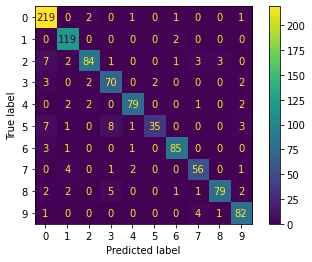

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn)
disp = disp.plot()
plt.show()

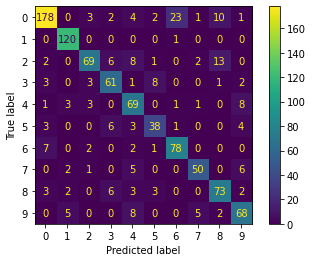

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dbc)
disp = disp.plot()
plt.show()

### Task 2: Implement a multi-class perceptron algorithm

In [30]:
X_train = pd.read_csv('./data/train_in.csv',header=None)
Y_train = pd.read_csv('./data/train_out.csv',header=None)
X_test = pd.read_csv('./data/test_in.csv',header=None)
Y_test = pd.read_csv('./data/test_out.csv',header=None)
df_train = X_train.copy()
df_train['label']=Y_train
T_train=X_train.copy()
T_train['bias']=1
T_test=X_test.copy()
T_test['bias']=1

Perceptron in pseudo code:
initialize weights at random. <br>
while there are misclassified examples: <br>
  for  misclassified examples:<br>
    if W_prediction > W_label: W_pred = W_pred-X<br>
    and W_label=W_label + X<br>


In [31]:
class MultiClassPerceptron:
    def __init__(self):
        self.weigths=None
    
    def fit(self,X,Y):
        W_x=X.shape[1]
        W_y=Y.shape[0]
        total=len(Y_train)
        W,counter,times_right,score=self.initialize((W_x,W_y))        
        
        while ((score<0.90) | (counter<30)):
            prediction=np.argmax(np.dot(X,W),axis=1)
            for i,(pred,label) in enumerate(zip(prediction,Y.values[:,0])):
                if pred != label:
                    W[:,pred]-=T_train.iloc[i]*(W[:,pred]>W[:,label])
                    W[:,label]+=T_train.iloc[i]*(W[:,pred]>W[:,label])
            times_right=sum(prediction.T==Y.values[:,0])
            score=times_right/total    
            counter+=1
        print(f'iterations: {counter}, times right: {times_right},percentage: {score}')
        self.weigths=W
        
    def predict(self,X):
        W=self.weigths
        prediction=np.argmax(np.dot(X,W),axis=1)
        return prediction
    
    def initialize(self,shape):
        W=np.random.random(shape)
        (counter,times_right,score)=(0,0,0)
        return (W,counter,times_right,score)
    
    def score(self,X,Y):
        predictions=self.predict(X)
        acc=(np.sum(predictions==Y.values.T))/len(Y)
        return acc


In [32]:
mcp=MultiClassPerceptron()
mcp.fit(T_train,Y_train)

iteration: 30, times right: 1578,percentage: 0.9244288224956063


In [33]:
Y_pred_mcp=mcp.predict(T_test)

In [34]:
print(classification_report(Y_test, Y_pred_mcp))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       224
           1       0.95      0.95      0.95       121
           2       0.79      0.76      0.77       101
           3       0.85      0.77      0.81        79
           4       0.82      0.74      0.78        86
           5       0.75      0.65      0.70        55
           6       0.93      0.82      0.87        90
           7       0.72      0.89      0.80        64
           8       0.72      0.79      0.76        92
           9       0.87      0.82      0.84        88

    accuracy                           0.84      1000
   macro avg       0.83      0.82      0.82      1000
weighted avg       0.84      0.84      0.84      1000



In [35]:
mcp.score(T_test,Y_test)

0.84

### Task 3

In [36]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def xor_net(x1, x2,weights):
    '''
    input 2-d
    hidden layer1 2 nodes
    hidden layer2 1 node, activation: sigmoid
    '''
    W1=np.reshape(weights[:4],(2,2))
    b1=weights[4:6]
    W2=np.reshape(weights[6:8],(2,1))
    b2=weights[-1]
    
    #input layer
    X0=np.array([x1,x2]).T
    # hidden layer1
    A1=np.dot(X0,W1)+b1
    Y1=sigmoid(A1)
    #hidden layer2
    A2=np.dot(Y1,W2)+b2
    Y=sigmoid(A2)
    return (Y,Y1,A1,A2)

In [37]:
weights=np.random.random(9)
x1=2
x2=3
xor_net(x1,x2,weights)

(array([0.83538175]),
 array([0.97521556, 0.71715936]),
 array([3.67244248, 0.93041442]),
 array([1.62425962]))

In [38]:
def xor_net_2(x1, x2,weights):
    (w13,w14,w23,w24,w3y,w4y,bias3,bias4,biasy)=weights 
    Y=sigmoid(biasy+w3y*sigmoid(bias3+w13*x1+w23*x2)+w4y*sigmoid(bias4+w14*x1+w24*x2))
    return Y

weights = (biasy,bias3,bias4,w13,w14,w23,w24,w3y,w4y)

In [39]:
xor_net_2(x1, x2,weights)

0.8859677001990695

In [40]:
#define data with corresponding targets
x = {'x1':[0,0,1,1],'x2':[0,1,0,1]}
xdf = pd.DataFrame(data=x)
y = {'target':[0,1,1,0]}
ydf = pd.DataFrame(data=y)
df=xdf.copy()
df['target']=y['target']
df

,x1,x2,target
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


In [43]:
def mse(weights_initial,X_data,Y_data):
    sumerror=0
    for i in range(len(X_data['x1'])):
        errorsq = np.square(xor_net_2(X_data.iloc[i][0],X_data.iloc[i][1],weights_initial)
        -Y_data.iloc[i][0])
        sumerror+=errorsq
    mserror=sumerror/len(X_data['x1'])
    return mserror

def mse2(output,labels,W):
    mserror=np.square(output-labels).mean()
    return mserror,W

In [98]:
def grdmse(weights_initial,X_data,Y_data,delta):
    gradient=np.zeros(9)
    weights_delta=weights_initial.copy()
    for i in range(len(weights_initial)):
        weights_delta[i]+=delta
        gradient_i=(mse(weights_delta,X_data,Y_data)-mse(weights_initial,X_data,Y_data))/delta
        weights_delta[i]-=delta
        gradient[i]+=gradient_i
    return gradient

def grdmse2(weights,X,Y1,Y,label):
    W1=np.reshape(weights[:4],(2,2))
    b1=weights[4:6]
    W2=np.reshape(weights[6:8],(2,1))
    b2=weights[-1]
    #dif=np.sum(Y-label)
    N=len(Y)
    
    dW2=np.zeros(W2.shape)
    dW1=np.zeros(W1.shape)
    db1=np.zeros(b1.shape)
    db2=np.zeros(b2.shape)

    dW2=np.sum((2/N)*(Y-label)*Y*(1-Y)*Y1,axis=0)
    db2=np.sum((2/N)*(Y-label)*Y*(1-Y),axis=0)
    dW1[0,0]=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2[0]*np.reshape(Y1[:,0],(4,1))*(1-np.reshape(Y1[:,0],(4,1)))*np.reshape(X[:,0],(4,1)),axis=0)
    dW1[0,1]=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2[0]*np.reshape(Y1[:,0],(4,1))*(1-np.reshape(Y1[:,0],(4,1)))*np.reshape(X[:,1],(4,1)),axis=0)
    dW1[1,0]=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2[1]*np.reshape(Y1[:,1],(4,1))*(1-np.reshape(Y1[:,1],(4,1)))*np.reshape(X[:,0],(4,1)),axis=0)
    dW1[1,1]=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2[1]*np.reshape(Y1[:,1],(4,1))*(1-np.reshape(Y1[:,1],(4,1)))*np.reshape(X[:,1],(4,1)),axis=0)
    db1[0]=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2[0]*np.reshape(Y1[:,0],(4,1))*(1-np.reshape(Y1[:,0],(4,1))),axis=0)
    db1[1]=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2[1]*np.reshape(Y1[:,1],(4,1))*(1-np.reshape(Y1[:,1],(4,1))),axis=0)
    """
    dW2=np.sum((2/N)*(Y-label)*Y*(1-Y)*Y1,axis=0)
    db2=np.sum((2/N)*(Y-label)*Y*(1-Y),axis=0)
    dW1=np.sum((2/N)*(Y-label)*Y*(1-Y)*np.hstack([W2,W2])*Y1*(1-Y1)*X,axis=0)
    db1=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2*Y1*(1-Y1),axis=0)
    """
    #Y1*(1-Y1)*X*((Y*(1-Y)*(label-Y))*W2.T)
    
    d_weights=np.hstack([W1.ravel(),b1.ravel(),W2.ravel(),b2.ravel()])
    return d_weights

In [45]:
def discpred(X_data,Y_data,weights_initial): 
    #makes a list of discrete predictions from the continuous predictions
    disclist=np.zeros(len(X_data['x1']))
    for i in range(len(X_data['x1'])):
        if xor_net_2(X_data.iloc[i][0],X_data.iloc[i][1],weights_initial)<0.5:
            disclist[i]=0    
        else:
            disclist[i]=1
    return disclist
            

In [49]:
def xor_values(weights_initial,X_data,Y_data): 
    #shows prediction values, only for testing purposes
    print(xor_net_2(0,0,weights_initial))
    print(xor_net_2(0,1,weights_initial))
    print(xor_net_2(1,0,weights_initial))
    print(xor_net_2(1,1,weights_initial))

In [50]:
def countpred(weights_initial,X_data,Y_data):
    predcount=np.sum(discpred(X_data,Y_data,weights_initial)!=ydf.values.T)
    return predcount

In [52]:
def grddescentmse(X_data,Y_data,delta,eta,treshold): 
    #the gradient descent algorithm, iterating until the error has a certain treshold
    weights=10*(np.random.random(9)-0.5)
    i=0
    while mse(weights,X_data,Y_data)>treshold: #can also be while countpred!=0
        if i<100:
            weights-=eta*grdmse(weights,X_data,Y_data,delta)
            i+=1
            print(f'MSE: {mse(weights,X_data,Y_data)},Number of misclassifications: {countpred(weights,X_data,Y_data)} Iterations: {i}')
        else:
            print('RESTART')
            i=0
            weights=10*(np.random.random(9)-0.5)
    return weights

In [53]:
def grddescentpred(X_data,Y_data,delta,eta): 
    #the gradient descent algorithm, iterating until the error has a certain treshold
    weights=10*(np.random.random(9)-0.5)
    i=0
    while countpred(weights,X_data,Y_data)!=0:
        if i<100:
            weights-=eta*grdmse(weights,X_data,Y_data,delta)
            i+=1
            print(f'MSE: {mse(weights,X_data,Y_data)},Number of misclassifications: {countpred(weights,X_data,Y_data)} Iterations: {i}')
        else:
            print('RESTART')
            i=0
            weights=10*(np.random.random(9)-0.5)
    return weights

In [54]:
weights=grddescentpred(xdf,ydf,0.0001,0.5)

MSE: 0.3083867469508818,Number of misclassifications: 3 Iterations: 1
MSE: 0.30684963758359035,Number of misclassifications: 3 Iterations: 2
MSE: 0.3053654890453406,Number of misclassifications: 3 Iterations: 3
MSE: 0.30393255322084783,Number of misclassifications: 3 Iterations: 4
MSE: 0.30254894816560435,Number of misclassifications: 3 Iterations: 5
MSE: 0.301212691752505,Number of misclassifications: 3 Iterations: 6
MSE: 0.2999217329709063,Number of misclassifications: 3 Iterations: 7
MSE: 0.2986739805434319,Number of misclassifications: 3 Iterations: 8
MSE: 0.2974673286486725,Number of misclassifications: 3 Iterations: 9
MSE: 0.2962996796486519,Number of misclassifications: 3 Iterations: 10
MSE: 0.29516896381219865,Number of misclassifications: 3 Iterations: 11
MSE: 0.29407315610407003,Number of misclassifications: 3 Iterations: 12
MSE: 0.29301029016830354,Number of misclassifications: 3 Iterations: 13
MSE: 0.291978469679903,Number of misclassifications: 3 Iterations: 14
MSE: 0.2909

MSE: 0.44131733530520045,Number of misclassifications: 2 Iterations: 25
MSE: 0.43968917539187846,Number of misclassifications: 2 Iterations: 26
MSE: 0.4379879661415585,Number of misclassifications: 2 Iterations: 27
MSE: 0.43620983926349177,Number of misclassifications: 2 Iterations: 28
MSE: 0.43435079598181325,Number of misclassifications: 2 Iterations: 29
MSE: 0.43240672757436127,Number of misclassifications: 2 Iterations: 30
MSE: 0.43037344336031375,Number of misclassifications: 2 Iterations: 31
MSE: 0.4282467076358463,Number of misclassifications: 2 Iterations: 32
MSE: 0.42602228722879065,Number of misclassifications: 2 Iterations: 33
MSE: 0.42369601148764613,Number of misclassifications: 2 Iterations: 34
MSE: 0.4212638466158132,Number of misclassifications: 2 Iterations: 35
MSE: 0.41872198627012147,Number of misclassifications: 2 Iterations: 36
MSE: 0.41606696021959017,Number of misclassifications: 2 Iterations: 37
MSE: 0.41329576255145195,Number of misclassifications: 2 Iterations

MSE: 0.43665012956031596,Number of misclassifications: 2 Iterations: 41
MSE: 0.43495791588416854,Number of misclassifications: 2 Iterations: 42
MSE: 0.4332370163432309,Number of misclassifications: 2 Iterations: 43
MSE: 0.43148841319537756,Number of misclassifications: 2 Iterations: 44
MSE: 0.42971315839726665,Number of misclassifications: 2 Iterations: 45
MSE: 0.427912367778447,Number of misclassifications: 2 Iterations: 46
MSE: 0.4260872139799163,Number of misclassifications: 2 Iterations: 47
MSE: 0.4242389180707916,Number of misclassifications: 2 Iterations: 48
MSE: 0.42236873976368317,Number of misclassifications: 2 Iterations: 49
MSE: 0.420477966162177,Number of misclassifications: 2 Iterations: 50
MSE: 0.41856789898672986,Number of misclassifications: 2 Iterations: 51
MSE: 0.41663984024353373,Number of misclassifications: 2 Iterations: 52
MSE: 0.4146950763188106,Number of misclassifications: 2 Iterations: 53
MSE: 0.4127348605022718,Number of misclassifications: 2 Iterations: 54
M

MSE: 0.4950682730707575,Number of misclassifications: 2 Iterations: 67
MSE: 0.4950460679849784,Number of misclassifications: 2 Iterations: 68
MSE: 0.49502366587113394,Number of misclassifications: 2 Iterations: 69
MSE: 0.49500106412313866,Number of misclassifications: 2 Iterations: 70
MSE: 0.4949782600891005,Number of misclassifications: 2 Iterations: 71
MSE: 0.4949552510703146,Number of misclassifications: 2 Iterations: 72
MSE: 0.49493203432024435,Number of misclassifications: 2 Iterations: 73
MSE: 0.4949086070434181,Number of misclassifications: 2 Iterations: 74
MSE: 0.49488496639439955,Number of misclassifications: 2 Iterations: 75
MSE: 0.4948611094766088,Number of misclassifications: 2 Iterations: 76
MSE: 0.49483703334124446,Number of misclassifications: 2 Iterations: 77
MSE: 0.4948127349860624,Number of misclassifications: 2 Iterations: 78
MSE: 0.49478821135416845,Number of misclassifications: 2 Iterations: 79
MSE: 0.49476345933279914,Number of misclassifications: 2 Iterations: 80

MSE: 0.18294003766691794,Number of misclassifications: 1 Iterations: 87
MSE: 0.18277063860022164,Number of misclassifications: 1 Iterations: 88
MSE: 0.18260452756133821,Number of misclassifications: 1 Iterations: 89
MSE: 0.18244162703239625,Number of misclassifications: 1 Iterations: 90
MSE: 0.18228186125542467,Number of misclassifications: 1 Iterations: 91
MSE: 0.18212515622944941,Number of misclassifications: 1 Iterations: 92
MSE: 0.18197143970257662,Number of misclassifications: 1 Iterations: 93
MSE: 0.18182064115960503,Number of misclassifications: 1 Iterations: 94
MSE: 0.1816726918056792,Number of misclassifications: 1 Iterations: 95
MSE: 0.18152752454656812,Number of misclassifications: 1 Iterations: 96
MSE: 0.1813850739659528,Number of misclassifications: 1 Iterations: 97
MSE: 0.18124527630028792,Number of misclassifications: 1 Iterations: 98
MSE: 0.18110806941140534,Number of misclassifications: 1 Iterations: 99
MSE: 0.18097339275744392,Number of misclassifications: 1 Iteration

MSE: 0.46890542135419566,Number of misclassifications: 2 Iterations: 2
MSE: 0.46851586998938377,Number of misclassifications: 2 Iterations: 3
MSE: 0.4681178108573647,Number of misclassifications: 2 Iterations: 4
MSE: 0.4677109968926135,Number of misclassifications: 2 Iterations: 5
MSE: 0.46729517269579857,Number of misclassifications: 2 Iterations: 6
MSE: 0.46687007424711513,Number of misclassifications: 2 Iterations: 7
MSE: 0.4664354286120949,Number of misclassifications: 2 Iterations: 8
MSE: 0.4659909536401682,Number of misclassifications: 2 Iterations: 9
MSE: 0.46553635765603396,Number of misclassifications: 2 Iterations: 10
MSE: 0.4650713391443717,Number of misclassifications: 2 Iterations: 11
MSE: 0.4645955864277919,Number of misclassifications: 2 Iterations: 12
MSE: 0.46410877733900596,Number of misclassifications: 2 Iterations: 13
MSE: 0.46361057888728185,Number of misclassifications: 2 Iterations: 14
MSE: 0.4631006469198956,Number of misclassifications: 2 Iterations: 15
MSE: 0.

MSE: 0.3790973843634169,Number of misclassifications: 2 Iterations: 18
MSE: 0.37842274653752694,Number of misclassifications: 2 Iterations: 19
MSE: 0.3777534514996917,Number of misclassifications: 2 Iterations: 20
MSE: 0.3770878225766523,Number of misclassifications: 2 Iterations: 21
MSE: 0.37642423172107986,Number of misclassifications: 2 Iterations: 22
MSE: 0.37576108636441585,Number of misclassifications: 2 Iterations: 23
MSE: 0.3750968167451647,Number of misclassifications: 2 Iterations: 24
MSE: 0.3744298635615284,Number of misclassifications: 2 Iterations: 25
MSE: 0.3737586657981306,Number of misclassifications: 2 Iterations: 26
MSE: 0.3730816485756985,Number of misclassifications: 2 Iterations: 27
MSE: 0.37239721087066724,Number of misclassifications: 2 Iterations: 28
MSE: 0.37170371294717686,Number of misclassifications: 2 Iterations: 29
MSE: 0.37099946333770717,Number of misclassifications: 2 Iterations: 30
MSE: 0.37028270519978634,Number of misclassifications: 2 Iterations: 31

MSE: 0.4997245513203452,Number of misclassifications: 2 Iterations: 41
MSE: 0.4997244752101246,Number of misclassifications: 2 Iterations: 42
MSE: 0.4997243990578751,Number of misclassifications: 2 Iterations: 43
MSE: 0.4997243228635616,Number of misclassifications: 2 Iterations: 44
MSE: 0.4997242466271495,Number of misclassifications: 2 Iterations: 45
MSE: 0.49972417034860384,Number of misclassifications: 2 Iterations: 46
MSE: 0.49972409402788975,Number of misclassifications: 2 Iterations: 47
MSE: 0.4997240176649724,Number of misclassifications: 2 Iterations: 48
MSE: 0.49972394125981634,Number of misclassifications: 2 Iterations: 49
MSE: 0.499723864812387,Number of misclassifications: 2 Iterations: 50
MSE: 0.4997237883226492,Number of misclassifications: 2 Iterations: 51
MSE: 0.4997237117905678,Number of misclassifications: 2 Iterations: 52
MSE: 0.49972363521610785,Number of misclassifications: 2 Iterations: 53
MSE: 0.49972355859923395,Number of misclassifications: 2 Iterations: 54
MS

MSE: 0.3064934670930159,Number of misclassifications: 2 Iterations: 67
MSE: 0.30477140110803363,Number of misclassifications: 2 Iterations: 68
MSE: 0.3030972458707508,Number of misclassifications: 2 Iterations: 69
MSE: 0.30147311979716085,Number of misclassifications: 2 Iterations: 70
MSE: 0.2999006439926521,Number of misclassifications: 2 Iterations: 71
MSE: 0.29838092207998995,Number of misclassifications: 2 Iterations: 72
MSE: 0.29691453602313633,Number of misclassifications: 2 Iterations: 73
MSE: 0.2955015570852815,Number of misclassifications: 2 Iterations: 74
MSE: 0.2941415703794614,Number of misclassifications: 2 Iterations: 75
MSE: 0.29283371094144184,Number of misclassifications: 2 Iterations: 76
MSE: 0.29157670890215975,Number of misclassifications: 2 Iterations: 77
MSE: 0.29036894117172546,Number of misclassifications: 2 Iterations: 78
MSE: 0.2892084870576674,Number of misclassifications: 2 Iterations: 79
MSE: 0.2880931853988733,Number of misclassifications: 2 Iterations: 80

MSE: 0.23732663648901609,Number of misclassifications: 2 Iterations: 84
MSE: 0.23682800959046996,Number of misclassifications: 2 Iterations: 85
MSE: 0.23633669252606057,Number of misclassifications: 2 Iterations: 86
MSE: 0.2358525300289338,Number of misclassifications: 2 Iterations: 87
MSE: 0.23537536730938236,Number of misclassifications: 2 Iterations: 88
MSE: 0.2349050504179941,Number of misclassifications: 2 Iterations: 89
MSE: 0.23444142656802594,Number of misclassifications: 2 Iterations: 90
MSE: 0.2339843444194099,Number of misclassifications: 2 Iterations: 91
MSE: 0.23353365432685227,Number of misclassifications: 2 Iterations: 92
MSE: 0.23308920855480333,Number of misclassifications: 2 Iterations: 93
MSE: 0.23265086146169395,Number of misclassifications: 2 Iterations: 94
MSE: 0.232218469656205,Number of misclassifications: 2 Iterations: 95
MSE: 0.23179189212799511,Number of misclassifications: 2 Iterations: 96
MSE: 0.23137099035546305,Number of misclassifications: 2 Iterations: 

MSE: 0.49868842200179225,Number of misclassifications: 2 Iterations: 6
MSE: 0.4986862717365511,Number of misclassifications: 2 Iterations: 7
MSE: 0.4986841139255015,Number of misclassifications: 2 Iterations: 8
MSE: 0.4986819485276224,Number of misclassifications: 2 Iterations: 9
MSE: 0.49867977550158804,Number of misclassifications: 2 Iterations: 10
MSE: 0.49867759480576856,Number of misclassifications: 2 Iterations: 11
MSE: 0.49867540639822405,Number of misclassifications: 2 Iterations: 12
MSE: 0.49867321023670586,Number of misclassifications: 2 Iterations: 13
MSE: 0.49867100627864513,Number of misclassifications: 2 Iterations: 14
MSE: 0.49866879448116314,Number of misclassifications: 2 Iterations: 15
MSE: 0.4986665748010636,Number of misclassifications: 2 Iterations: 16
MSE: 0.4986643471948208,Number of misclassifications: 2 Iterations: 17
MSE: 0.4986621116185855,Number of misclassifications: 2 Iterations: 18
MSE: 0.4986598680281762,Number of misclassifications: 2 Iterations: 19
MSE

MSE: 0.2641928903361813,Number of misclassifications: 1 Iterations: 25
MSE: 0.26354338240691105,Number of misclassifications: 1 Iterations: 26
MSE: 0.2629501175193128,Number of misclassifications: 1 Iterations: 27
MSE: 0.2624011116998772,Number of misclassifications: 1 Iterations: 28
MSE: 0.2618871334096968,Number of misclassifications: 1 Iterations: 29
MSE: 0.26140108704951454,Number of misclassifications: 1 Iterations: 30
MSE: 0.26093752719251273,Number of misclassifications: 1 Iterations: 31
MSE: 0.2604922790796555,Number of misclassifications: 1 Iterations: 32
MSE: 0.2600621439658287,Number of misclassifications: 1 Iterations: 33
MSE: 0.25964467137813085,Number of misclassifications: 1 Iterations: 34
MSE: 0.2592379836727943,Number of misclassifications: 1 Iterations: 35
MSE: 0.25884064120829336,Number of misclassifications: 1 Iterations: 36
MSE: 0.2584515389156562,Number of misclassifications: 1 Iterations: 37
MSE: 0.2580698270585399,Number of misclassifications: 2 Iterations: 38
M

MSE: 0.1957172700262666,Number of misclassifications: 1 Iterations: 45
MSE: 0.19491983212173297,Number of misclassifications: 1 Iterations: 46
MSE: 0.19423351811716827,Number of misclassifications: 1 Iterations: 47
MSE: 0.1936425743349079,Number of misclassifications: 1 Iterations: 48
MSE: 0.19313318339474933,Number of misclassifications: 1 Iterations: 49
MSE: 0.1926933003452701,Number of misclassifications: 1 Iterations: 50
MSE: 0.192312483680598,Number of misclassifications: 1 Iterations: 51
MSE: 0.19198172743914793,Number of misclassifications: 1 Iterations: 52
MSE: 0.19169329910106148,Number of misclassifications: 1 Iterations: 53
MSE: 0.1914405866316814,Number of misclassifications: 1 Iterations: 54
MSE: 0.19121795683108628,Number of misclassifications: 1 Iterations: 55
MSE: 0.19102062617443577,Number of misclassifications: 1 Iterations: 56
MSE: 0.19084454456597588,Number of misclassifications: 1 Iterations: 57
MSE: 0.1906862918636723,Number of misclassifications: 1 Iterations: 58

KeyboardInterrupt: 

Below I will try to discretize the prediction inside the gradient computation to get better results. This results in a gradient of zero for all weights.

In [321]:
def grddisc(weights_initial,X_data,Y_data,delta): #here i try to determine the gradient with a discrete loss count
    gradient=np.zeros(9)
    weights_delta=weights_initial.copy()
    for i in range(len(weights_initial)):
        weights_delta[i]+=delta
        gradient_i=(countpred(weights_delta,X_data,Y_data)-countpred(weights_initial,X_data,Y_data))/delta
        weights_delta[i]-=delta
        gradient[i]+=gradient_i
    return gradient

In [121]:
#initialisatie
x1=np.array([0,0,1,1])
x2=np.array([0,1,0,1])
X=np.array([x1,x2]).T
label=np.array([0,1,1,0]).reshape(4,1)

#weights random
weights=(12*np.random.random(9))-5
weights[4:6]/=10
weights[-1]/=10
#weights=np.ones(9)/3
#learning rate
etha=0.1

epochs=5000
done=False



In [122]:
k=0
while mis_qualified!=0:
    errors={}
    misses={}
    weights=(12*np.random.random(9))-5
    weights[4:6]/=10
    weights[-1]/=10
    for i in range(epochs):
        #forward step
        Y,Y1,A1,A2=xor_net(x1, x2,weights)        
        #loss function
        error,W=mse2(Y,label,weights)
        #back prop
        d_weights=grdmse2(weights,X,Y1,Y,label)
        #update weights
        weights=weights-etha*d_weights
        mis_qualified=np.sum((Y>0.5)!=label)
        errors[i]=error
        misses[i]=mis_qualified
        if mis_qualified==0:
            break
    print(f'try {k}, mis={mis_qualified}, min_loss={min(errors.values())} ')
    k+=1

try 0, mis=2, min_loss=0.25 
try 1, mis=2, min_loss=0.25 
try 2, mis=2, min_loss=0.24999999999999997 
try 3, mis=2, min_loss=0.25 
try 4, mis=2, min_loss=0.25 
try 5, mis=2, min_loss=0.24999999999999997 
try 6, mis=2, min_loss=0.25 
try 7, mis=2, min_loss=0.24999999999999997 
try 8, mis=2, min_loss=0.24999999999999997 
try 9, mis=2, min_loss=0.24999999999999997 
try 10, mis=2, min_loss=0.24999999999999997 
try 11, mis=2, min_loss=0.24999999999999997 
try 12, mis=2, min_loss=0.24999999999999997 
try 13, mis=2, min_loss=0.24999999999999997 
try 14, mis=2, min_loss=0.24999999999999997 
try 15, mis=2, min_loss=0.24999999999999997 
try 16, mis=2, min_loss=0.24999999999999997 
try 17, mis=2, min_loss=0.21480312399264562 
try 18, mis=2, min_loss=0.24999999999999997 
try 19, mis=2, min_loss=0.24999999999999997 
try 20, mis=2, min_loss=0.24999999999999997 
try 21, mis=2, min_loss=0.24999999999999997 
try 22, mis=2, min_loss=0.24999999999999997 
try 23, mis=2, min_loss=0.25 
try 24, mis=2, min_l

KeyboardInterrupt: 

In [ ]:
x1=np.array([0,0,1,1])
x2=np.array([0,1,0,1])
X=np.array([x1,x2]).T
label=np.array([0,1,1,0]).reshape(4,1)

#weights random
weights=np.random.random(9)


In [97]:
#forward step
Y,Y1,A1,A2=xor_net(x1, x2,weights)        
#loss function
error,W=mse2(Y,label,weights)

#backprop

W1=np.reshape(weights[:4],(2,2))
b1=weights[4:6]
W2=np.reshape(weights[6:8],(2,1))
b2=weights[-1]
N=len(Y)

dW2=np.zeros(W2.shape)
dW1=np.zeros(W1.shape)
db1=np.zeros(b1.shape)
db2=np.zeros(b2.shape)

dW2=np.sum((2/N)*(Y-label)*Y*(1-Y)*Y1,axis=0)
db2=np.sum((2/N)*(Y-label)*Y*(1-Y),axis=0)
dW1[0,0]=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2[0]*np.reshape(Y1[:,0],(4,1))*(1-np.reshape(Y1[:,0],(4,1)))*np.reshape(X[:,0],(4,1)),axis=0)
dW1[0,1]=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2[0]*np.reshape(Y1[:,0],(4,1))*(1-np.reshape(Y1[:,0],(4,1)))*np.reshape(X[:,1],(4,1)),axis=0)
dW1[1,0]=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2[1]*np.reshape(Y1[:,1],(4,1))*(1-np.reshape(Y1[:,1],(4,1)))*np.reshape(X[:,0],(4,1)),axis=0)
dW1[1,1]=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2[1]*np.reshape(Y1[:,1],(4,1))*(1-np.reshape(Y1[:,1],(4,1)))*np.reshape(X[:,1],(4,1)),axis=0)
db1[0]=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2[0]*np.reshape(Y1[:,0],(4,1))*(1-np.reshape(Y1[:,0],(4,1))),axis=0)
db1[1]=np.sum((2/N)*(Y-label)*Y*(1-Y)*W2[1]*np.reshape(Y1[:,1],(4,1))*(1-np.reshape(Y1[:,1],(4,1))),axis=0)


d_weights=np.hstack([W1.ravel(),b1.ravel(),W2.ravel(),b2.ravel()])
d_weights

array([ 2.81978229,  4.84453799, -2.18555361,  0.93400323,  3.45428855,
       -0.49767677, -0.6890707 ,  4.09013171, -0.55614603])

In [123]:
def lazy_method(X_data,Y_data):#randomly initialize weights to find the network that predicts perfectly
    weights=(np.random.random(9)-0.5)*10
    i=0
    while countpred(weights,X_data,Y_data)!=0:
        weights=(np.random.random(9)-0.5)*10
        i+=1
        print(f'iteration: {i}, wrong predictions:{countpred(weights,X_data,Y_data)}')
        print(discpred(X_data,Y_data,weights))
    return i
        
        

In [124]:
lazy_method(xdf,ydf)

iteration: 1, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3, wrong predictions:2
[1. 1. 1. 1.]
iteration: 4, wrong predictions:2
[1. 1. 1. 1.]
iteration: 5, wrong predictions:2
[1. 1. 1. 1.]
iteration: 6, wrong predictions:2
[1. 1. 1. 1.]
iteration: 7, wrong predictions:2
[1. 1. 1. 1.]
iteration: 8, wrong predictions:2
[0. 0. 0. 0.]
iteration: 9, wrong predictions:2
[0. 1. 0. 1.]
iteration: 10, wrong predictions:3
[1. 0. 1. 1.]
iteration: 11, wrong predictions:3
[0. 0. 0. 1.]
iteration: 12, wrong predictions:1
[1. 1. 1. 0.]
iteration: 13, wrong predictions:3
[1. 0. 0. 0.]
iteration: 14, wrong predictions:2
[1. 1. 1. 1.]
iteration: 15, wrong predictions:2
[0. 0. 0. 0.]
iteration: 16, wrong predictions:2
[1. 1. 1. 1.]
iteration: 17, wrong predictions:2
[0. 0. 0. 0.]
iteration: 18, wrong predictions:2
[0. 0. 0. 0.]
iteration: 19, wrong predictions:2
[1. 1. 1. 1.]
iteration: 20, wrong predictions:2
[1. 1. 0. 0.]
iteration: 21, wrong predicti

iteration: 184, wrong predictions:2
[1. 1. 1. 1.]
iteration: 185, wrong predictions:2
[0. 0. 0. 0.]
iteration: 186, wrong predictions:2
[1. 1. 1. 1.]
iteration: 187, wrong predictions:2
[0. 0. 0. 0.]
iteration: 188, wrong predictions:2
[1. 1. 1. 1.]
iteration: 189, wrong predictions:2
[1. 0. 1. 0.]
iteration: 190, wrong predictions:2
[1. 1. 1. 1.]
iteration: 191, wrong predictions:2
[0. 0. 0. 0.]
iteration: 192, wrong predictions:2
[1. 1. 1. 1.]
iteration: 193, wrong predictions:2
[0. 0. 0. 0.]
iteration: 194, wrong predictions:2
[0. 0. 0. 0.]
iteration: 195, wrong predictions:2
[1. 1. 1. 1.]
iteration: 196, wrong predictions:2
[0. 0. 0. 0.]
iteration: 197, wrong predictions:2
[1. 1. 1. 1.]
iteration: 198, wrong predictions:2
[0. 0. 0. 0.]
iteration: 199, wrong predictions:2
[1. 1. 1. 1.]
iteration: 200, wrong predictions:2
[0. 0. 0. 0.]
iteration: 201, wrong predictions:2
[1. 1. 1. 1.]
iteration: 202, wrong predictions:2
[0. 0. 0. 0.]
iteration: 203, wrong predictions:2
[0. 0. 0. 0.]


[1. 1. 1. 1.]
iteration: 363, wrong predictions:2
[1. 1. 1. 1.]
iteration: 364, wrong predictions:2
[0. 0. 0. 0.]
iteration: 365, wrong predictions:2
[1. 1. 1. 1.]
iteration: 366, wrong predictions:2
[0. 0. 0. 0.]
iteration: 367, wrong predictions:1
[0. 1. 0. 0.]
iteration: 368, wrong predictions:2
[0. 0. 0. 0.]
iteration: 369, wrong predictions:3
[1. 0. 0. 0.]
iteration: 370, wrong predictions:2
[1. 1. 1. 1.]
iteration: 371, wrong predictions:2
[0. 0. 1. 1.]
iteration: 372, wrong predictions:2
[0. 0. 0. 0.]
iteration: 373, wrong predictions:2
[0. 0. 0. 0.]
iteration: 374, wrong predictions:2
[1. 1. 1. 1.]
iteration: 375, wrong predictions:2
[1. 1. 1. 1.]
iteration: 376, wrong predictions:2
[1. 1. 1. 1.]
iteration: 377, wrong predictions:2
[0. 0. 0. 0.]
iteration: 378, wrong predictions:1
[0. 1. 1. 1.]
iteration: 379, wrong predictions:2
[0. 0. 0. 0.]
iteration: 380, wrong predictions:2
[0. 0. 0. 0.]
iteration: 381, wrong predictions:2
[0. 0. 0. 0.]
iteration: 382, wrong predictions:2


[1. 1. 1. 1.]
iteration: 608, wrong predictions:2
[0. 0. 0. 0.]
iteration: 609, wrong predictions:3
[1. 0. 1. 1.]
iteration: 610, wrong predictions:2
[1. 1. 1. 1.]
iteration: 611, wrong predictions:2
[1. 1. 1. 1.]
iteration: 612, wrong predictions:2
[1. 1. 1. 1.]
iteration: 613, wrong predictions:2
[0. 1. 0. 1.]
iteration: 614, wrong predictions:2
[1. 1. 1. 1.]
iteration: 615, wrong predictions:2
[1. 0. 1. 0.]
iteration: 616, wrong predictions:2
[1. 1. 1. 1.]
iteration: 617, wrong predictions:2
[1. 1. 1. 1.]
iteration: 618, wrong predictions:2
[0. 0. 0. 0.]
iteration: 619, wrong predictions:2
[1. 1. 1. 1.]
iteration: 620, wrong predictions:2
[1. 1. 1. 1.]
iteration: 621, wrong predictions:2
[0. 0. 0. 0.]
iteration: 622, wrong predictions:2
[0. 0. 0. 0.]
iteration: 623, wrong predictions:2
[0. 1. 0. 1.]
iteration: 624, wrong predictions:2
[1. 1. 1. 1.]
iteration: 625, wrong predictions:1
[0. 1. 0. 0.]
iteration: 626, wrong predictions:2
[1. 1. 1. 1.]
iteration: 627, wrong predictions:2


iteration: 780, wrong predictions:2
[1. 1. 1. 1.]
iteration: 781, wrong predictions:2
[0. 0. 0. 0.]
iteration: 782, wrong predictions:2
[1. 1. 1. 1.]
iteration: 783, wrong predictions:2
[0. 0. 0. 0.]
iteration: 784, wrong predictions:2
[1. 1. 1. 1.]
iteration: 785, wrong predictions:2
[0. 0. 0. 0.]
iteration: 786, wrong predictions:2
[1. 1. 1. 1.]
iteration: 787, wrong predictions:2
[0. 0. 0. 0.]
iteration: 788, wrong predictions:2
[0. 0. 0. 0.]
iteration: 789, wrong predictions:2
[1. 1. 1. 1.]
iteration: 790, wrong predictions:2
[0. 0. 0. 0.]
iteration: 791, wrong predictions:2
[1. 1. 1. 1.]
iteration: 792, wrong predictions:2
[1. 1. 1. 1.]
iteration: 793, wrong predictions:2
[1. 1. 1. 1.]
iteration: 794, wrong predictions:3
[1. 1. 0. 1.]
iteration: 795, wrong predictions:2
[1. 0. 1. 0.]
iteration: 796, wrong predictions:2
[1. 1. 1. 1.]
iteration: 797, wrong predictions:2
[1. 1. 1. 1.]
iteration: 798, wrong predictions:2
[1. 1. 1. 1.]
iteration: 799, wrong predictions:2
[1. 1. 1. 1.]


iteration: 1011, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1012, wrong predictions:3
[1. 0. 1. 1.]
iteration: 1013, wrong predictions:3
[1. 1. 0. 1.]
iteration: 1014, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1015, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1016, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1017, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1018, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1019, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1020, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1021, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1022, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1023, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1024, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1025, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1026, wrong predictions:1
[0. 1. 0. 0.]
iteration: 1027, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1028, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1029, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1030, wrong predicti

[1. 1. 1. 1.]
iteration: 1224, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1225, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1226, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1227, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1228, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1229, wrong predictions:3
[1. 0. 1. 1.]
iteration: 1230, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1231, wrong predictions:3
[1. 1. 0. 1.]
iteration: 1232, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1233, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1234, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1235, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1236, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1237, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1238, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1239, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1240, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1241, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1242, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1243, 

[0. 0. 0. 0.]
iteration: 1499, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1500, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1501, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1502, wrong predictions:1
[0. 1. 0. 0.]
iteration: 1503, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1504, wrong predictions:2
[0. 0. 1. 1.]
iteration: 1505, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1506, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1507, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1508, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1509, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1510, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1511, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1512, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1513, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1514, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1515, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1516, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1517, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1518, 

iteration: 1699, wrong predictions:1
[0. 1. 0. 0.]
iteration: 1700, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1701, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1702, wrong predictions:2
[1. 0. 1. 0.]
iteration: 1703, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1704, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1705, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1706, wrong predictions:3
[1. 0. 1. 1.]
iteration: 1707, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1708, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1709, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1710, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1711, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1712, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1713, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1714, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1715, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1716, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1717, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1718, wrong predicti

iteration: 1987, wrong predictions:3
[1. 1. 0. 1.]
iteration: 1988, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1989, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1990, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1991, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1992, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1993, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1994, wrong predictions:2
[1. 0. 1. 0.]
iteration: 1995, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1996, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1997, wrong predictions:2
[1. 1. 1. 1.]
iteration: 1998, wrong predictions:2
[0. 0. 0. 0.]
iteration: 1999, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2000, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2001, wrong predictions:3
[0. 0. 0. 1.]
iteration: 2002, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2003, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2004, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2005, wrong predictions:3
[1. 1. 0. 1.]
iteration: 2006, wrong predicti

iteration: 2193, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2194, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2195, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2196, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2197, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2198, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2199, wrong predictions:3
[1. 0. 1. 1.]
iteration: 2200, wrong predictions:2
[0. 1. 0. 1.]
iteration: 2201, wrong predictions:3
[1. 0. 1. 1.]
iteration: 2202, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2203, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2204, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2205, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2206, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2207, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2208, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2209, wrong predictions:2
[0. 1. 0. 1.]
iteration: 2210, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2211, wrong predictions:2
[1. 0. 1. 0.]
iteration: 2212, wrong predicti

iteration: 2382, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2383, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2384, wrong predictions:1
[1. 1. 1. 0.]
iteration: 2385, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2386, wrong predictions:2
[0. 0. 1. 1.]
iteration: 2387, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2388, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2389, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2390, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2391, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2392, wrong predictions:1
[0. 1. 1. 1.]
iteration: 2393, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2394, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2395, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2396, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2397, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2398, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2399, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2400, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2401, wrong predicti

iteration: 2560, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2561, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2562, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2563, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2564, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2565, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2566, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2567, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2568, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2569, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2570, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2571, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2572, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2573, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2574, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2575, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2576, wrong predictions:3
[1. 0. 0. 0.]
iteration: 2577, wrong predictions:1
[0. 1. 0. 0.]
iteration: 2578, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2579, wrong predicti

iteration: 2756, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2757, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2758, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2759, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2760, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2761, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2762, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2763, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2764, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2765, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2766, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2767, wrong predictions:1
[0. 1. 0. 0.]
iteration: 2768, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2769, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2770, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2771, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2772, wrong predictions:2
[0. 0. 1. 1.]
iteration: 2773, wrong predictions:3
[0. 0. 0. 1.]
iteration: 2774, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2775, wrong predicti

[0. 0. 0. 0.]
iteration: 2956, wrong predictions:3
[1. 0. 0. 0.]
iteration: 2957, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2958, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2959, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2960, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2961, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2962, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2963, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2964, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2965, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2966, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2967, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2968, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2969, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2970, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2971, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2972, wrong predictions:2
[0. 0. 0. 0.]
iteration: 2973, wrong predictions:2
[1. 1. 1. 1.]
iteration: 2974, wrong predictions:2
[1. 0. 1. 0.]
iteration: 2975, 

iteration: 3157, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3158, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3159, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3160, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3161, wrong predictions:1
[0. 1. 1. 1.]
iteration: 3162, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3163, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3164, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3165, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3166, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3167, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3168, wrong predictions:3
[1. 1. 0. 1.]
iteration: 3169, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3170, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3171, wrong predictions:3
[0. 0. 0. 1.]
iteration: 3172, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3173, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3174, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3175, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3176, wrong predicti

[1. 1. 1. 1.]
iteration: 3321, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3322, wrong predictions:1
[0. 0. 1. 0.]
iteration: 3323, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3324, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3325, wrong predictions:1
[0. 1. 0. 0.]
iteration: 3326, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3327, wrong predictions:1
[0. 0. 1. 0.]
iteration: 3328, wrong predictions:1
[1. 1. 1. 0.]
iteration: 3329, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3330, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3331, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3332, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3333, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3334, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3335, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3336, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3337, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3338, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3339, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3340, 

iteration: 3482, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3483, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3484, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3485, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3486, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3487, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3488, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3489, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3490, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3491, wrong predictions:2
[1. 1. 0. 0.]
iteration: 3492, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3493, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3494, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3495, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3496, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3497, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3498, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3499, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3500, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3501, wrong predicti

[1. 1. 1. 1.]
iteration: 3706, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3707, wrong predictions:1
[0. 0. 1. 0.]
iteration: 3708, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3709, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3710, wrong predictions:2
[1. 0. 1. 0.]
iteration: 3711, wrong predictions:2
[0. 0. 1. 1.]
iteration: 3712, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3713, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3714, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3715, wrong predictions:3
[1. 0. 1. 1.]
iteration: 3716, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3717, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3718, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3719, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3720, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3721, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3722, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3723, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3724, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3725, 

[0. 0. 0. 0.]
iteration: 3889, wrong predictions:1
[0. 1. 1. 1.]
iteration: 3890, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3891, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3892, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3893, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3894, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3895, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3896, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3897, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3898, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3899, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3900, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3901, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3902, wrong predictions:1
[0. 1. 1. 1.]
iteration: 3903, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3904, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3905, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3906, wrong predictions:2
[1. 1. 1. 1.]
iteration: 3907, wrong predictions:2
[0. 0. 0. 0.]
iteration: 3908, 

iteration: 4067, wrong predictions:2
[1. 1. 1. 1.]
iteration: 4068, wrong predictions:2
[0. 0. 1. 1.]
iteration: 4069, wrong predictions:1
[0. 0. 1. 0.]
iteration: 4070, wrong predictions:2
[0. 0. 0. 0.]
iteration: 4071, wrong predictions:2
[0. 0. 0. 0.]
iteration: 4072, wrong predictions:2
[0. 0. 0. 0.]
iteration: 4073, wrong predictions:2
[0. 0. 0. 0.]
iteration: 4074, wrong predictions:2
[1. 1. 1. 1.]
iteration: 4075, wrong predictions:2
[0. 0. 0. 0.]
iteration: 4076, wrong predictions:2
[1. 1. 1. 1.]
iteration: 4077, wrong predictions:2
[1. 1. 1. 1.]
iteration: 4078, wrong predictions:2
[1. 1. 1. 1.]
iteration: 4079, wrong predictions:2
[0. 0. 0. 0.]
iteration: 4080, wrong predictions:2
[1. 1. 1. 1.]
iteration: 4081, wrong predictions:2
[1. 1. 1. 1.]
iteration: 4082, wrong predictions:2
[1. 1. 1. 1.]
iteration: 4083, wrong predictions:2
[0. 0. 0. 0.]
iteration: 4084, wrong predictions:2
[1. 1. 1. 1.]
iteration: 4085, wrong predictions:2
[0. 0. 0. 0.]
iteration: 4086, wrong predicti

4177

In [319]:
def test_lazy_method(xdf,ydf,measurements): #create a list with n experiments of the lazy method
    results=np.zeros(measurements)
    for n in range(measurements):
            results[n]=lazy_method(xdf,ydf)
    return results

In [295]:
lazy_method_test=test_lazy_method(xdf,ydf,10)

iteration: 1, countpred:2
[0. 0. 0. 0.]
iteration: 2, countpred:2
[1. 1. 1. 1.]
iteration: 3, countpred:2
[1. 1. 1. 1.]
iteration: 4, countpred:2
[1. 1. 1. 1.]
iteration: 5, countpred:2
[1. 1. 1. 1.]
iteration: 6, countpred:2
[0. 0. 0. 0.]
iteration: 7, countpred:2
[1. 1. 1. 1.]
iteration: 8, countpred:2
[0. 0. 0. 0.]
iteration: 9, countpred:2
[1. 1. 1. 1.]
iteration: 10, countpred:3
[1. 0. 0. 0.]
iteration: 11, countpred:2
[0. 0. 0. 0.]
iteration: 12, countpred:2
[1. 1. 1. 1.]
iteration: 13, countpred:2
[0. 0. 0. 0.]
iteration: 14, countpred:3
[1. 0. 0. 0.]
iteration: 15, countpred:2
[0. 0. 0. 0.]
iteration: 16, countpred:2
[0. 0. 0. 0.]
iteration: 17, countpred:2
[1. 1. 1. 1.]
iteration: 18, countpred:2
[0. 1. 0. 1.]
iteration: 19, countpred:2
[0. 0. 0. 0.]
iteration: 20, countpred:2
[1. 1. 1. 1.]
iteration: 21, countpred:2
[1. 1. 1. 1.]
iteration: 22, countpred:2
[0. 0. 0. 0.]
iteration: 23, countpred:2
[1. 1. 1. 1.]
iteration: 24, countpred:2
[1. 1. 1. 1.]
iteration: 25, countpred:

In [307]:
print('number of iterations: '+str(lazy_method_test))
print('mean value: '+str(np.mean(lazy_method_test)))

number of iterations: [  661.  4085.  1561.  3448.  4841.  1738.  1211.  1390.  8623. 19400.]
mean value: 4695.8
